In [1]:
import tensorflow as tf
from keras import layers
from keras.models import Model, Sequential
from keras import backend as K
from sklearn.metrics import mean_squared_error
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import TensorBoard,ModelCheckpoint
#_optimizer = Adam(0.0002, 0.9)
_optimizer = Adam(0.001, 0.9, decay=0.0001)
from keras import losses

# from tensorflow.keras import layers
# from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# from IPython import display
from tqdm import tqdm
import os

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

#!ls "/content/drive/My Drive"

In [3]:
def encoder_block(_filters, _kernel_size, _strides, bn = True):
    y = Sequential()
    y.add(layers.Conv2D(filters = _filters, kernel_size = _kernel_size, 
                      strides = _strides, padding="same",
                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02)))
    if bn is True:
        y.add(layers.BatchNormalization(momentum = 0.9, epsilon=1e-5))
    y.add(layers.ReLU())
    return y

In [4]:
def decoder_block(_filters, _kernel_size, _strides, dropout = False):
    y = Sequential()
    y.add(layers.Conv2DTranspose(filters = _filters, kernel_size = _kernel_size,
                               strides=_strides, padding="same",
                               kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
    y.add(layers.BatchNormalization(momentum = 0.9, epsilon=1e-5))
    if dropout is True:
        y.add(layers.Dropout(0.5))
    y.add(layers.ReLU())
    return y

In [5]:
# def fcn():
#     inputs = layers.Input(shape=(256, 256, 3))
#     enc1 = encoder_block(32, (5, 5), (4, 4), bn = False)(inputs)
#     dec1 = decoder_block(16, (5, 5), (4, 4))(enc1)
#     model = Model(inputs=inputs, outputs=dec1)
#     return model

# img1 = layers.Input(shape=(256, 256, 3))
# img2 = layers.Input(shape=(256, 256, 3))
# Layer = fcn()
# a1 = Layer(img1)
# a2 = Layer(img2)
# b = layers.Concatenate()([a1, a2])
# model = Model(inputs = [img1, img2], outputs = b)
# model.summary()

In [6]:
def encoder_net():
    inputs = layers.Input(shape=(None, None, 3))
    enc1 = encoder_block(32, (5, 5), (4, 4), bn = False)(inputs)
    enc2 = encoder_block(128, (5, 5), (4, 4))(enc1)
    enc3 = encoder_block(128, (5, 5), (4, 4))(enc2)
#     enc4 = encoder_block(256, (5, 5), (4, 4))(enc3)
    
#     dec1 = decoder_block(2, (5, 5), (4, 4))(enc4)
#     dec1 = layers.Concatenate(axis = -1)([enc3, dec1])
    dec2 = decoder_block(2, (5, 5), (4, 4))(enc3)
    dec2 = layers.Concatenate()([enc2, dec2])
    dec3 = decoder_block(2, (5, 5), (4, 4), False)(dec2)
    dec3 = layers.Concatenate()([enc1, dec3])
    dec4 = decoder_block(2, (5, 5), (4, 4))(dec3)
    dec4 = layers.Concatenate()([inputs, dec4])
    
    model = Model(inputs = inputs, outputs = dec4)
    return model

In [7]:
def decoder_net(Enc):
    inputs = layers.Input(shape=(None, None, 10))

#     dec1 = decoder_block(256, (5, 5), (4, 4))(inputs)
#     dec1 = layers.Concatenate(axis = -1)([Enc.layers[-1], dec1])
#     dec2 = decoder_block(256, (5, 5), (4, 4), False)(dec1)
#     dec2 = layers.Concatenate()([Enc.layers[-1], dec2])
#     dec3 = decoder_block(128, (5, 5), (4, 4), False)(dec2)
#     dec3 = layers.Concatenate()([Enc.layers[-1], dec3])
#     dec4 = decoder_block(32, (5, 5), (4, 4), False)(dec3)
#     dec4 = layers.Concatenate()([Enc.layers[-1], dec4])
    dec5 = encoder_block(8, (5, 5), (1, 1), bn = False)(inputs)
    dec6 = layers.Conv2D(filters = 1, kernel_size = (5, 5), padding = "same",
                      activation="tanh",
                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(dec5)
    model = Model(inputs = inputs, outputs = dec6)
    return model

In [8]:
def fusionnet(inTensor1, inTensor2):
    Enc = encoder_net()
    out1 = Enc(inTensor1)
    out2 = Enc(inTensor2)
    x = layers.Concatenate(axis = -1)([out1, out2])
    y = decoder_net(Enc)(x)
    return y

In [9]:
def fusionnetPos(y):
    y, inTensor1, inTensor2 = y
    y = K.tile(y, [1, 1, 1, 3])
    y1 = layers.Multiply()([inTensor1, (1+y)/2])
    y2 = layers.Multiply()([inTensor2, 1-(1+y)/2])
    y = layers.Add()([y1, y2])
    return y

In [10]:
img1 = layers.Input(shape=(None, None, 3))
img2 = layers.Input(shape=(None, None, 3))
intermed = fusionnet(img1, img2) # intermed: mask layer

pred = layers.Lambda(fusionnetPos)([intermed, img1, img2])

In [11]:
'''2 outputs: 'pred' for GAN loss and 'intermed' for mask loss'''
generator = Model(inputs = [img1, img2], outputs = pred)
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, None, None, 5 530342      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, None, None, 1 0           model_1[1][0]                    
          

In [12]:
def load_imgs(path, number, train_type):
    result1=np.zeros((number, 256, 256, 3), dtype=np.uint8)
    result2=np.zeros((number, 256, 256, 3), dtype=np.uint8)
    result0=np.zeros((number, 256, 256, 3), dtype=np.uint8)

    i = 0
    while i < number:
        img_idx = 1+np.random.randint(1454)
        I1 = cv2.imread(path + "{:04}_{}.png".format(img_idx, 1))
        I2 = cv2.imread(path + "{:04}_{}.png".format(img_idx, 2))
        I0 = cv2.imread(path + "{:04}_{}.png".format(img_idx, 0))        
        if I0 is None or min(I0.shape[:2]) < 256:
            continue
        m, n = I0.shape[:2]
        m_b = np.random.randint(m-255)
        n_b = np.random.randint(n-255)
        result1[i, :, :, :] = I1[m_b:m_b+256, n_b:n_b+256, :]
        result2[i, :, :, :] = I2[m_b:m_b+256, n_b:n_b+256, :]
        result0[i, :, :, :] = I0[m_b:m_b+256, n_b:n_b+256, :]
        i += 1
    return result1, result2, result0

In [13]:
path = 'ImagePair/'
num = 10000

x1, x2, y = load_imgs(path, num, 1)

    
x_train1, x_test1, x_train2, x_test2, y_train, y_test = train_test_split(
    x1, x2, y, test_size=0.2, random_state=7412)

In [14]:
# idx = 121
# plt.imshow(x_train1[idx, :, :, :])
# plt.show()
# plt.imshow(x_train2[idx, :, :, :])
# plt.show()
# plt.imshow(y_train[idx, :, :, :])
# plt.show()

In [15]:
def data_aug(img):
    # normalization
    # change constract/brightness inside pair
    # add noise
    # change color
    pass
    

In [16]:
def data_gen(features, labels, batch_size):
    features1, features2 = features
 # Create empty arrays to contain batch of features and labels#
    batch_features1 = np.zeros((batch_size, 256, 256, 3))
    batch_features2 = np.zeros((batch_size, 256, 256, 3))
    batch_labels = np.zeros((batch_size, 256, 256, 3))
    while True:
        for i in np.arange(0, features1.shape[0] - batch_size, batch_size):
            # choose random index in features
            batch_features1 = features1[i:i+batch_size, :, :, :].astype('float16')/127.5-1
            batch_features2 = features2[i:i+batch_size, :, :, :].astype('float16')/127.5-1
            batch_labels= labels[i:i+batch_size, :, :, :].astype('float16')/127.5-1
            yield ([batch_features1, batch_features2], batch_labels)

In [17]:
tcbc = TensorBoard(log_dir='1')
filepath="models/{epoch:03d}-{val_loss:.5f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',period=1)

In [18]:
batch_size = 16
epochs = 1
generator.compile(loss='mse', optimizer= 'Adam')
history = generator.fit_generator(data_gen([x_train1, x_train2], y_train, batch_size), 
                    steps_per_epoch = x_train1.shape[0]//batch_size, epochs = epochs,
                    validation_data=data_gen([x_test1, x_test2], y_test, batch_size), 
                    validation_steps = batch_size,verbose=1, callbacks = [tcbc, checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
50/50 [==============================] - 14s 271ms/step - loss: 0.0063 - val_loss: 0.0034

Epoch 00001: val_loss improved from inf to 0.00336, saving model to models/001-0.00336.hdf5
Epoch 2/10
50/50 [==============================] - 9s 176ms/step - loss: 0.0030 - val_loss: 0.0028

Epoch 00002: val_loss improved from 0.00336 to 0.00284, saving model to models/002-0.00284.hdf5
Epoch 3/10
50/50 [==============================] - 9s 186ms/step - loss: 0.0023 - val_loss: 0.0024

Epoch 00003: val_loss improved from 0.00284 to 0.00241, saving model to models/003-0.00241.hdf5
Epoch 4/10
50/50 [==============================] - 9s 181ms/step - loss: 0.0020 - val_loss: 0.0021

Epoch 00004: val_loss improved from 0.00241 to 0.00213, saving model to models/004-0.00213.hdf5
Epoch 5/10
50/50 [==============================] - 9s 182ms/step - loss: 0.0018 - val_loss: 0.0024

Epoch 00005: val_loss did not improve from 0.00213
Epoch 6/10
50/5

(1080, 1920, 3)
255


True

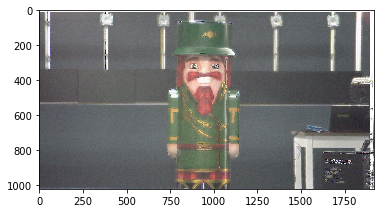

In [53]:
# I1 = cv2.imread('/home/qian/Documents/FusionNet/1.jpg')
# I2 = cv2.imread('/home/qian/Documents/FusionNet/2.jpg')
# I1 = cv2.resize(I1,(1920, 1080))
# I2 = cv2.resize(I2,(1920, 1080))
# print(I1.shape)
# print(I1.max())

# I1 = I1[np.newaxis, :1024, :, :]/127.5-1
# I2 = I2[np.newaxis, :1024, :, :]/127.5-1
# pred = generator.predict([I1, I2])
# plt.imshow((pred[0, :, :, ::-1]+1)/2)
# cv2.imwrite('b.jpg',(((pred[0, :, :, :]+1)/2)*255).astype('uint8'))
# cv2.imwrite('c.jpg',((I1[0, :, :, :]+I2[0, :, :, :]+2)/4*255).astype('uint8'))

In [56]:
generator.save('models/g.h5')

In [19]:
# prediction= generator.predict([x_test1[:25, :, :, :]/127.5-1, x_test2[:25, :, :, :]/127.5-1])#, y_test[:25, :, :, :]/127.5-1)
# for imgIdx in range(5):
#     fig=plt.figure(figsize=(32, 32))
#     columns = 4
#     rows = 1
#     fig.add_subplot(rows, columns, 1)
#     plt.imshow(x_test1[imgIdx, :, :, ::-1])
#     fig.add_subplot(rows, columns, 2)
#     plt.imshow(x_test2[imgIdx, :, :, ::-1])
#     fig.add_subplot(rows, columns, 3)
#     plt.imshow((prediction[imgIdx, :, :, ::-1]+1)/2)
#     fig.add_subplot(rows, columns, 4)
#     plt.imshow(y_test[imgIdx, :, :, ::-1])
#     plt.show()   

In [58]:
from keras.models import load_model
generator = load_model('models/g.h5')

NameError: name 'layers' is not defined

WoodenHouse
Frame 2 (╬╗ = 4,22).jpg
Frame 0 (╬╗ = 2,21).jpg
Frame 3 (╬╗ = 5,23).jpg
Frame 1 (╬╗ = 3,21).jpg
Frame 4 (╬╗ = 6,24).jpg
5


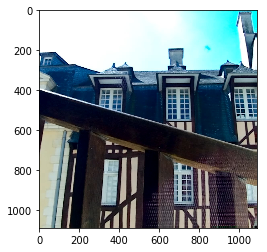

Fruits
Frame 1 (╬╗ = -1,84).jpg
Frame 3 (╬╗ = 3,15).jpg
Frame 5 (╬╗ = 5,73).jpg
Frame 11 (╬╗ = 13,21).jpg
Frame 4 (╬╗ = 4,15).jpg
Frame 7 (╬╗ = 8,18).jpg
Frame 2 (╬╗ = 1,76).jpg
Frame 6 (╬╗ = 7,17).jpg
Frame 10 (╬╗ = 11,20).jpg
Frame 9 (╬╗ = 10,19).jpg
Frame 8 (╬╗ = 9,19).jpg
Frame 0 (╬╗ = -2,89).jpg
12


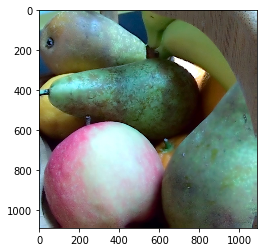

BSNMom
Frame 1 (╬╗ = -1,77).jpg
Frame 2 (╬╗ = 1,31).jpg
Frame 3 (╬╗ = 3,61).jpg
Frame 4 (╬╗ = 5,20).jpg
Frame 5 (╬╗ = 6,21).jpg
Frame 0 (╬╗ = -2,86).jpg
Frame 6 (╬╗ = 7,22).jpg
Frame 7 (╬╗ = 8,23).jpg
8


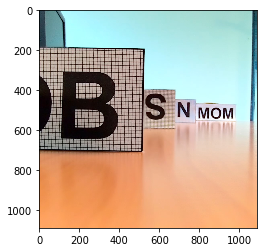

TapeMeasure
Frame 10 (╬╗ = 17,24).jpg
Frame 2 (╬╗ = -1,47).jpg
Frame 1 (╬╗ = -4,28).jpg
Frame 9 (╬╗ = 16,23).jpg
Frame 7 (╬╗ = 12,45).jpg
Frame 6 (╬╗ = 9,54).jpg
Frame 8 (╬╗ = 14,22).jpg
Frame 11 (╬╗ = 18,25).jpg
Frame 4 (╬╗ = 4,62).jpg
Frame 0 (╬╗ = -9,47).jpg
Frame 3 (╬╗ = 2,04).jpg
Frame 5 (╬╗ = 7,34).jpg
12


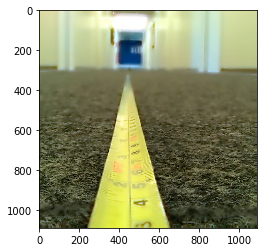

LongExposure_Aya
Frame 0 (╬╗ = 1,20).jpg
Frame 3 (╬╗ = 5,20).jpg
Frame 5 (╬╗ = 7,22).jpg
Frame 2 (╬╗ = 4,02).jpg
Frame 1 (╬╗ = 2,18).jpg
Frame 4 (╬╗ = 6,21).jpg
6


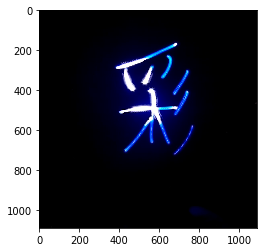

Flower
Frame 4 (╬╗ = -4,88).jpg
Frame 8 (╬╗ = 1,61).jpg
Frame 0 (╬╗ = -9,43).jpg
Frame 7 (╬╗ = -1,65).jpg
Frame 6 (╬╗ = -2,86).jpg
Frame 9 (╬╗ = 5,90).jpg
Frame 1 (╬╗ = -7,90).jpg
Frame 10 (╬╗ = 7,22).jpg
Frame 5 (╬╗ = -3,87).jpg
Frame 3 (╬╗ = -5,89).jpg
Frame 2 (╬╗ = -6,89).jpg
Frame 11 (╬╗ = 8,23).jpg
12


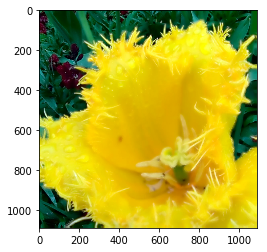

Beers
Frame 4 (╬╗ = -4,48).jpg
Frame 6 (╬╗ = 1,21).jpg
Frame 2 (╬╗ = -7,56).jpg
Frame 1 (╬╗ = -8,88).jpg
Frame 0 (╬╗ = -9,89).jpg
Frame 5 (╬╗ = -1,57).jpg
Frame 3 (╬╗ = -5,85).jpg
Frame 7 (╬╗ = 2,24).jpg
8


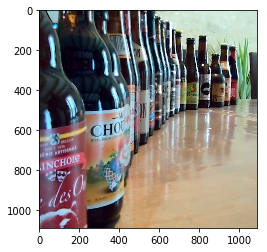

Riponne
Frame 9 (╬╗ = 2,21).jpg
Frame 8 (╬╗ = 1,20).jpg
Frame 3 (╬╗ = -14,95).jpg
Frame 7 (╬╗ = -0,34).jpg
Frame 4 (╬╗ = -13,68).jpg
Frame 0 (╬╗ = -17,98).jpg
Frame 2 (╬╗ = -15,96).jpg
Frame 1 (╬╗ = -16,97).jpg
Frame 5 (╬╗ = -9,18).jpg
Frame 11 (╬╗ = 4,22).jpg
Frame 10 (╬╗ = 3,21).jpg
Frame 6 (╬╗ = -4,26).jpg
12


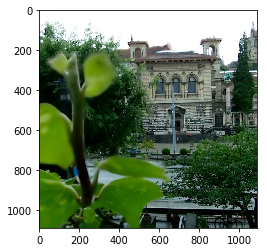

TotoroWaterfall
Frame 2 (╬╗ = -4,86).jpg
Frame 6 (╬╗ = 1,20).jpg
Frame 10 (╬╗ = 5,23).jpg
Frame 4 (╬╗ = -1,20).jpg
Frame 8 (╬╗ = 3,21).jpg
Frame 7 (╬╗ = 2,21).jpg
Frame 9 (╬╗ = 4,22).jpg
Frame 5 (╬╗ = 0,10).jpg
Frame 1 (╬╗ = -6,11).jpg
Frame 0 (╬╗ = -6,88).jpg
Frame 3 (╬╗ = -3,57).jpg
11


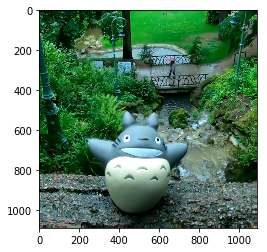

Ground
Frame 5 (╬╗ = 2,19).jpg
Frame 10 (╬╗ = 8,23).jpg
Frame 1 (╬╗ = -8,92).jpg
Frame 7 (╬╗ = 5,20).jpg
Frame 0 (╬╗ = -13,42).jpg
Frame 4 (╬╗ = -0,68).jpg
Frame 2 (╬╗ = -6,24).jpg
Frame 8 (╬╗ = 6,21).jpg
Frame 9 (╬╗ = 7,22).jpg
Frame 6 (╬╗ = 4,20).jpg
Frame 3 (╬╗ = -3,56).jpg
11


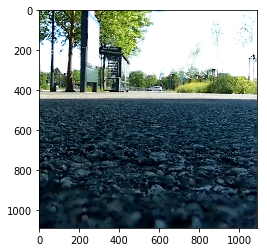

Statue
Frame 8 (╬╗ = 5,20).jpg
Frame 9 (╬╗ = 6,21).jpg
Frame 3 (╬╗ = -9,61).jpg
Frame 4 (╬╗ = -3,71).jpg
Frame 1 (╬╗ = -11,93).jpg
Frame 0 (╬╗ = -14,83).jpg
Frame 2 (╬╗ = -10,93).jpg
Frame 7 (╬╗ = 4,20).jpg
Frame 10 (╬╗ = 7,39).jpg
Frame 5 (╬╗ = 2,18).jpg
Frame 11 (╬╗ = 9,24).jpg
Frame 6 (╬╗ = 3,19).jpg
12


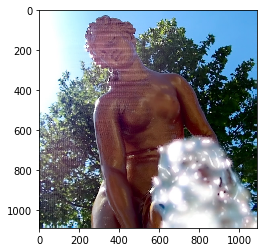

MotionBlur_Rearview
Frame 4 (╬╗ = 3,21).jpg
Frame 0 (╬╗ = -3,12).jpg
Frame 1 (╬╗ = -1,43).jpg
Frame 3 (╬╗ = 2,21).jpg
Frame 2 (╬╗ = 1,20).jpg
5


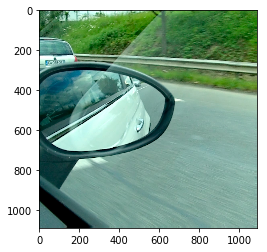

Watermelon
Frame 2 (╬╗ = -10,42).jpg
Frame 6 (╬╗ = 1,20).jpg
Frame 10 (╬╗ = 5,23).jpg
Frame 3 (╬╗ = -7,81).jpg
Frame 8 (╬╗ = 3,21).jpg
Frame 7 (╬╗ = 2,21).jpg
Frame 1 (╬╗ = -15,09).jpg
Frame 9 (╬╗ = 4,22).jpg
Frame 5 (╬╗ = -2,78).jpg
Frame 0 (╬╗ = -19,75).jpg
Frame 4 (╬╗ = -5,30).jpg
11


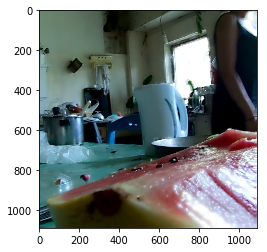

NotreDame
Frame 2 (╬╗ = 4,22).jpg
Frame 0 (╬╗ = 2,21).jpg
Frame 3 (╬╗ = 5,23).jpg
Frame 1 (╬╗ = 3,21).jpg
Frame 4 (╬╗ = 6,24).jpg
5


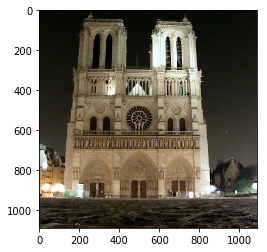

Rennes
Frame 4 (╬╗ = 3,19).jpg
Frame 1 (╬╗ = -1,63).jpg
Frame 0 (╬╗ = -2,92).jpg
Frame 6 (╬╗ = 5,20).jpg
Frame 3 (╬╗ = 2,18).jpg
Frame 7 (╬╗ = 6,21).jpg
Frame 5 (╬╗ = 4,20).jpg
Frame 2 (╬╗ = 1,20).jpg
8


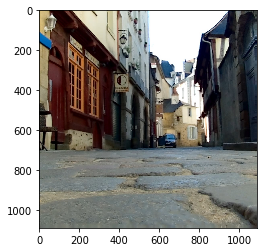

TootoroAlley
Frame 3 (╬╗ = 7,22).jpg
Frame 6 (╬╗ = 10,24).jpg
Frame 2 (╬╗ = 6,21).jpg
Frame 0 (╬╗ = -2,93).jpg
Frame 4 (╬╗ = 8,23).jpg
Frame 5 (╬╗ = 9,24).jpg
Frame 1 (╬╗ = 1,64).jpg
7


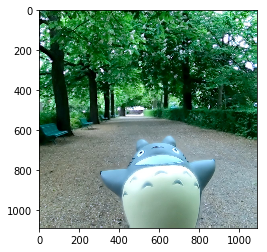

MotionBlur_EmergencyCallStation
Frame 3 (╬╗ = 6,24).jpg
Frame 1 (╬╗ = 4,22).jpg
Frame 2 (╬╗ = 5,23).jpg
Frame 0 (╬╗ = 3,21).jpg
Frame 4 (╬╗ = 7,00).jpg
5


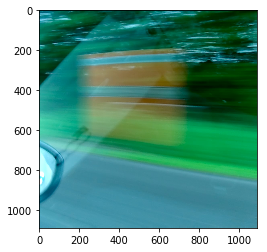

Edelweiss
Frame 9 (╬╗ = 2,21).jpg
Frame 8 (╬╗ = 1,20).jpg
Frame 3 (╬╗ = -15,96).jpg
Frame 1 (╬╗ = -18,99).jpg
Frame 6 (╬╗ = -5,87).jpg
Frame 2 (╬╗ = -17,15).jpg
Frame 5 (╬╗ = -9,78).jpg
Frame 7 (╬╗ = -0,87).jpg
Frame 11 (╬╗ = 4,22).jpg
Frame 0 (╬╗ = -19,75).jpg
Frame 4 (╬╗ = -13,69).jpg
Frame 10 (╬╗ = 3,21).jpg
12


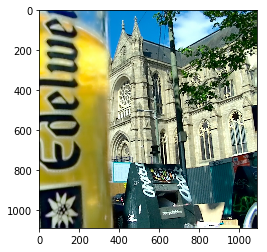

Cathedral
Frame 2 (╬╗ = -3,85).jpg
Frame 0 (╬╗ = -6,06).jpg
Frame 6 (╬╗ = 4,22).jpg
Frame 7 (╬╗ = 5,23).jpg
Frame 5 (╬╗ = 3,21).jpg
Frame 1 (╬╗ = -4,86).jpg
Frame 3 (╬╗ = -0,82).jpg
Frame 4 (╬╗ = 2,21).jpg
8


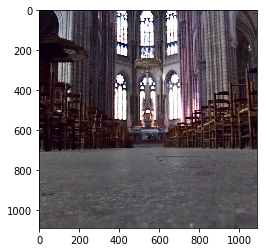

LoveLocks
Frame 8 (╬╗ = 5,20).jpg
Frame 3 (╬╗ = -2,86).jpg
Frame 9 (╬╗ = 6,21).jpg
Frame 0 (╬╗ = -6,02).jpg
Frame 1 (╬╗ = -4,88).jpg
Frame 7 (╬╗ = 4,20).jpg
Frame 10 (╬╗ = 7,22).jpg
Frame 5 (╬╗ = 1,52).jpg
Frame 2 (╬╗ = -3,87).jpg
Frame 6 (╬╗ = 3,19).jpg
Frame 4 (╬╗ = -1,53).jpg
11


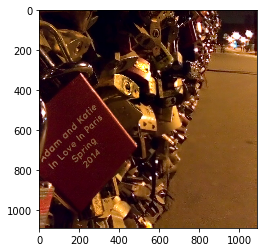

Cocktails
Frame 4 (╬╗ = 4,17).jpg
Frame 1 (╬╗ = -1,80).jpg
Frame 6 (╬╗ = 6,20).jpg
Frame 2 (╬╗ = 1,65).jpg
Frame 3 (╬╗ = 3,17).jpg
Frame 5 (╬╗ = 5,18).jpg
Frame 0 (╬╗ = -2,88).jpg
7


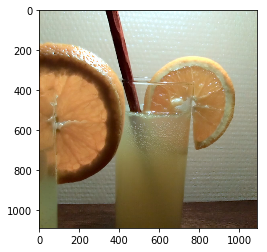

Guitar
Frame 5 (╬╗ = 5,26).jpg
Frame 8 (╬╗ = 12,99).jpg
Frame 7 (╬╗ = 12,19).jpg
Frame 2 (╬╗ = -5,63).jpg
Frame 9 (╬╗ = 14,20).jpg
Frame 3 (╬╗ = -2,90).jpg
Frame 11 (╬╗ = 16,21).jpg
Frame 6 (╬╗ = 9,64).jpg
Frame 10 (╬╗ = 15,20).jpg
Frame 0 (╬╗ = -14,25).jpg
Frame 1 (╬╗ = -9,00).jpg
Frame 4 (╬╗ = -0,19).jpg
12


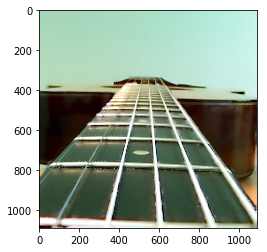

MotionBlur_Car
Frame 3 (╬╗ = 3,21).jpg
Frame 0 (╬╗ = -1,20).jpg
Frame 2 (╬╗ = 2,21).jpg
Frame 1 (╬╗ = 1,20).jpg
Frame 4 (╬╗ = 4,22).jpg
5


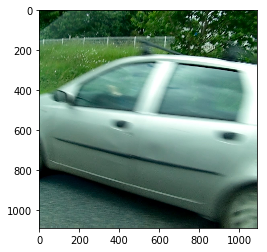

Dessert
Frame 4 (╬╗ = -4,33).jpg
Frame 10 (╬╗ = 4,20).jpg
Frame 6 (╬╗ = -1,64).jpg
Frame 8 (╬╗ = 2,18).jpg
Frame 0 (╬╗ = -9,92).jpg
Frame 2 (╬╗ = -7,29).jpg
Frame 7 (╬╗ = 1,20).jpg
Frame 5 (╬╗ = -2,86).jpg
Frame 3 (╬╗ = -5,89).jpg
Frame 11 (╬╗ = 5,20).jpg
Frame 9 (╬╗ = 3,19).jpg
Frame 1 (╬╗ = -8,91).jpg
12


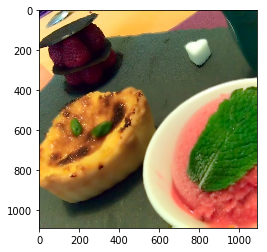

Flat_Toes
Frame 1 (╬╗ = 1,20).jpg
Frame 0 (╬╗ = -1,25).jpg
2


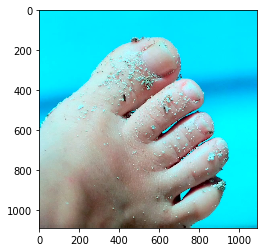

Grids
Frame 0 (╬╗ = -3,92).jpg
Frame 9 (╬╗ = 21,20).jpg
Frame 1 (╬╗ = -2,92).jpg
Frame 6 (╬╗ = 11,15).jpg
Frame 10 (╬╗ = 23,03).jpg
Frame 5 (╬╗ = 9,14).jpg
Frame 7 (╬╗ = 19,32).jpg
Frame 11 (╬╗ = 25,22).jpg
Frame 2 (╬╗ = -1,89).jpg
Frame 8 (╬╗ = 20,20).jpg
Frame 3 (╬╗ = 7,12).jpg
Frame 4 (╬╗ = 8,14).jpg
12


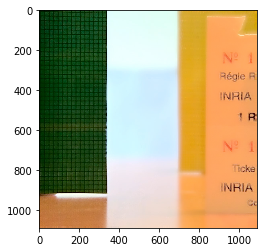

EPFL
Frame 4 (╬╗ = 3,21).jpg
Frame 6 (╬╗ = 5,23).jpg
Frame 1 (╬╗ = -3,81).jpg
Frame 3 (╬╗ = 1,67).jpg
Frame 2 (╬╗ = -1,68).jpg
Frame 5 (╬╗ = 4,22).jpg
Frame 7 (╬╗ = 6,24).jpg
Frame 0 (╬╗ = -7,20).jpg
8


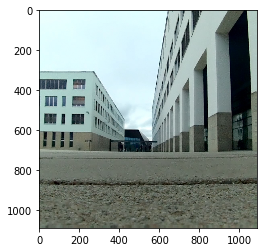

Cake
Frame 8 (╬╗ = 12,19).jpg
Frame 2 (╬╗ = 3,86).jpg
Frame 9 (╬╗ = 13,82).jpg
Frame 3 (╬╗ = 5,15).jpg
Frame 6 (╬╗ = 10,18).jpg
Frame 11 (╬╗ = 16,21).jpg
Frame 1 (╬╗ = 1,41).jpg
Frame 0 (╬╗ = -2,97).jpg
Frame 4 (╬╗ = 6,33).jpg
Frame 7 (╬╗ = 11,18).jpg
Frame 10 (╬╗ = 15,20).jpg
Frame 5 (╬╗ = 9,17).jpg
12


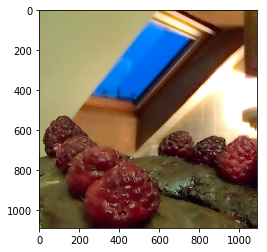

MGrid
Frame 2 (╬╗ = -2,92).jpg
Frame 4 (╬╗ = 3,41).jpg
Frame 3 (╬╗ = -1,91).jpg
Frame 0 (╬╗ = -4,93).jpg
Frame 5 (╬╗ = 8,73).jpg
Frame 6 (╬╗ = 14,05).jpg
Frame 1 (╬╗ = -3,92).jpg
7


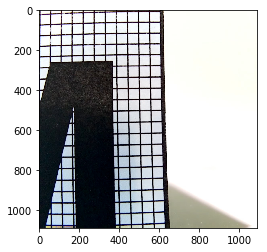

Street
Frame 0 (╬╗ = 1,20).jpg
Frame 4 (╬╗ = 5,23).jpg
Frame 2 (╬╗ = 3,21).jpg
Frame 3 (╬╗ = 4,22).jpg
Frame 1 (╬╗ = 2,21).jpg
5


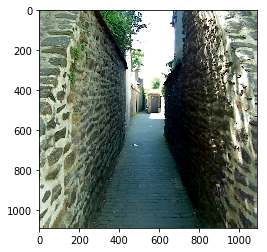

In [30]:
# def load_images_from_folder(folder):
#     images = []
#     for filename in os.listdir(folder):
#         if 'aif' in filename:
#             continue         
#         print(filename)
#         img = cv2.imread(os.path.join(folder,filename))

#         if img is not None:
#             #img = cv2.resize(img, (0,0), fx = 0.5, fy = 0.5)
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             images.append(img)
#     return images

# dataPath = "stacks/"
# for filename in os.listdir(dataPath):
#     print(filename)

#     dataPath_curr = dataPath + filename + "/";
#     focal_stack = load_images_from_folder(dataPath_curr)
#     print(len(focal_stack))
#     #focal_stack = focal_stack[:3]
#     dataNum = 1

#     prediction = focal_stack[0][np.newaxis, :, :, :]/127.5-1

#     for img in focal_stack:
#         x_test1 = prediction
#         x_test2 = img[np.newaxis, :, :, :]/127.5-1

#         prediction= generator.predict([x_test1, x_test2])
#   #   get_layer_output = K.function([generator.layers[0].input, generator.layers[1].input],
#   #                                     [generator.layers[-2].output])

#   #   layer_output = np.array(get_layer_output([x_test1/127.5-1, x_test2/127.5-1])[0])
  
#     I0=(prediction[0, :, :, :]+1)/2
#     plt.imshow(I0)
#     plt.show()
#     cv2.imwrite(dataPath_curr + 'aif.jpg',cv2.cvtColor((I0*255).astype('uint8'), cv2.COLOR_RGB2BGR))

In [21]:
# from keras.models import load_model
# generator = load_model('models/083-0.00027.hdf5')